In [2]:
import numpy as np
import pandas as pd
df1 = pd.read_csv('AAP.csv')
df2 = pd.read_csv('EBAY.csv')
df3 = pd.read_csv('MSFT.csv')
data1 = df1.sort_values('Date')
data2 = df2.sort_values('Date')
data3 = df3.sort_values('Date')

In [3]:
price1 = data1[['Close']]
price2 = data2[['Close']]
price3 = data3[['Close']]

In [4]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [5]:
lookback = 50 
x_train1, y_train1, x_test1, y_test1 = split_data(price1, lookback)
x_train2, y_train2, x_test2, y_test2 = split_data(price2, lookback)
x_train3, y_train3, x_test3, y_test3 = split_data(price3, lookback)

In [6]:
import torch
import torch.nn as nn

def np_to_tensor(a,b,c,d):
    x_train = torch.from_numpy(a).type(torch.Tensor)
    x_test = torch.from_numpy(b).type(torch.Tensor)
    y_train = torch.from_numpy(c).type(torch.Tensor)
    y_test = torch.from_numpy(d).type(torch.Tensor)
    return x_train, x_test, y_train, y_test

x_train1, x_test1, y_train1, y_test1 = np_to_tensor(x_train1, x_test1, y_train1, y_test1)
x_train2, x_test2, y_train2, y_test2 = np_to_tensor(x_train2, x_test2, y_train2, y_test2)
x_train3, x_test3, y_train3, y_test3 = np_to_tensor(x_train3, x_test3, y_train3, y_test3)


In [180]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [209]:
def trainLSTM(a,b,i_dim = 1, h_dim = 64, num_layers = 2, o_dim = 1, epochs = 500, lr = 0.01):
    model = LSTM(i_dim, h_dim, o_dim, num_layers)
    criterion = nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    hist = np.zeros(epochs)
    lstm = []
    for i in range(epochs):
        pred = model(a)
        loss = torch.sqrt(criterion(pred, b))
        print("Epoch ", i, "RMSE: ", loss.item())
        hist[i] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    return model, pred, hist

model, pred, hist = trainLSTM(x_train3, y_train3)
        

/home/kodakku-sensei/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning:

Using a target size (torch.Size([6827, 1])) that is different to the input size (torch.Size([6827, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch  0 RMSE:  22.53258514404297
Epoch  1 RMSE:  22.13039779663086
Epoch  2 RMSE:  21.736024856567383
Epoch  3 RMSE:  21.277374267578125
Epoch  4 RMSE:  20.777301788330078
Epoch  5 RMSE:  20.271089553833008
Epoch  6 RMSE:  19.799924850463867
Epoch  7 RMSE:  19.36517333984375
Epoch  8 RMSE:  18.962430953979492
Epoch  9 RMSE:  18.581188201904297
Epoch  10 RMSE:  18.211275100708008
Epoch  11 RMSE:  17.842708587646484
Epoch  12 RMSE:  17.467365264892578
Epoch  13 RMSE:  17.080690383911133
Epoch  14 RMSE:  16.679397583007812
Epoch  15 RMSE:  16.25664710998535
Epoch  16 RMSE:  15.819226264953613
Epoch  17 RMSE:  15.36460018157959
Epoch  18 RMSE:  14.933557510375977
Epoch  19 RMSE:  14.565832138061523
Epoch  20 RMSE:  14.153481483459473
Epoch  21 RMSE:  13.745121955871582
Epoch  22 RMSE:  13.339624404907227
Epoch  23 RMSE:  12.93895435333252
Epoch  24 RMSE:  12.556578636169434
Epoch  25 RMSE:  12.167250633239746
Epoch  26 RMSE:  11.780976295471191
Epoch  27 RMSE:  11.402156829833984
Epoch  2

In [210]:
predict = pd.DataFrame(pred.detach().numpy())
original = pd.DataFrame(y_train3.detach().numpy())

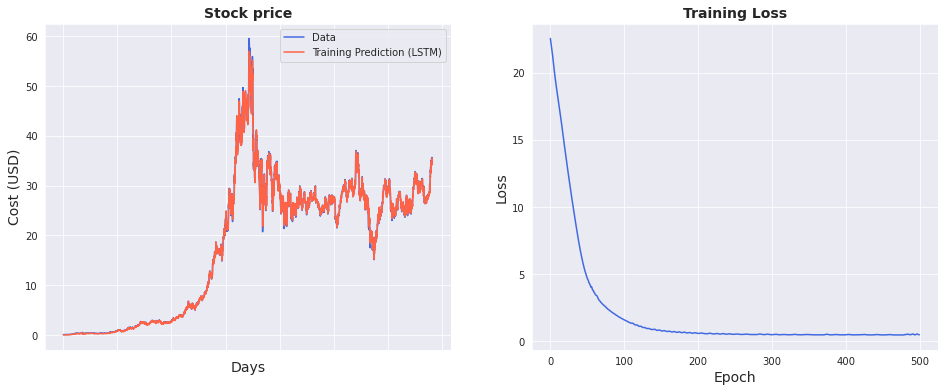

In [211]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [206]:
model

LSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [212]:
import math, time
y_test_pred = model(x_test3)
y_train_pred = pred.detach().numpy()
y_train = y_train3.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()
y_test = y_test3.detach().numpy()
a = np.delete(y_train_pred, 1, 1)
b = np.delete(y_test_pred, 1, 1)
trainPredictPlot = np.empty_like(price3)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = a
testPredictPlot = np.empty_like(price3)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price3)-1, :] = b
original = price3['Close']
predictions = pd.DataFrame(trainPredictPlot)
predictions[1] = testPredictPlot
predictions[2] = original
result = predictions
print(result)

       0          1           2
0    NaN        NaN    0.097222
1    NaN        NaN    0.100694
2    NaN        NaN    0.102431
3    NaN        NaN    0.099826
4    NaN        NaN    0.098090
...   ..        ...         ...
8579 NaN  56.726334  156.110001
8580 NaN  56.719612  149.699997
8581 NaN  56.730980  160.229996
8582 NaN  56.722717  157.710007
8583 NaN        NaN  152.110001

[8584 rows x 3 columns]


In [213]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [7]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [8]:
def trainGRU(a,b,i_dim = 1, h_dim = 64, num_layers = 2, o_dim = 1, epochs = 500, lr = 0.01):
    model = GRU(i_dim, h_dim, o_dim, num_layers)
    criterion = nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    hist = np.zeros(epochs)
    lstm = []
    for i in range(epochs):
        pred = model(a)
        loss = torch.sqrt(criterion(pred, b))
        print("Epoch ", i, "RMSE: ", loss.item())
        hist[i] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    return model, pred, hist

model, pred, hist = trainGRU(x_train3, y_train3)

/home/kodakku-sensei/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6827, 1])) that is different to the input size (torch.Size([6827, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  0 RMSE:  22.58045768737793
Epoch  1 RMSE:  21.83518409729004
Epoch  2 RMSE:  21.216989517211914
Epoch  3 RMSE:  20.6748046875
Epoch  4 RMSE:  20.16460609436035
Epoch  5 RMSE:  19.701345443725586
Epoch  6 RMSE:  19.269594192504883
Epoch  7 RMSE:  18.84999656677246
Epoch  8 RMSE:  18.433406829833984
Epoch  9 RMSE:  18.014814376831055
Epoch  10 RMSE:  17.593494415283203
Epoch  11 RMSE:  17.167978286743164
Epoch  12 RMSE:  16.736974716186523
Epoch  13 RMSE:  16.300533294677734
Epoch  14 RMSE:  15.860978126525879
Epoch  15 RMSE:  15.42159366607666
Epoch  16 RMSE:  14.982748985290527
Epoch  17 RMSE:  14.543316841125488
Epoch  18 RMSE:  14.10290241241455
Epoch  19 RMSE:  13.660981178283691
Epoch  20 RMSE:  13.217571258544922
Epoch  21 RMSE:  12.77740478515625
Epoch  22 RMSE:  12.343642234802246
Epoch  23 RMSE:  11.914270401000977
Epoch  24 RMSE:  11.487250328063965
Epoch  25 RMSE:  11.063518524169922
Epoch  26 RMSE:  10.643537521362305
Epoch  27 RMSE:  10.227624893188477
Epoch  28 RMSE

In [12]:
predict = pd.DataFrame((pred.detach().numpy()))
original = pd.DataFrame(y_train3.detach().numpy())

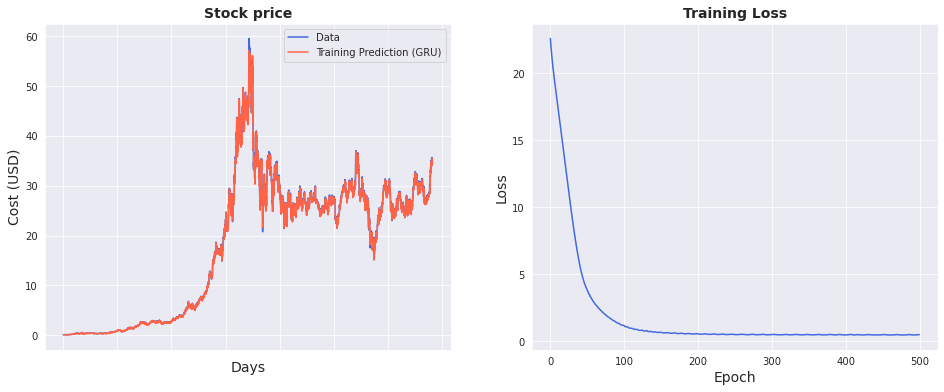

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [14]:
import math, time
from sklearn.metrics import mean_squared_error


y_test_pred = model(x_test3)


y_train_pred = pred.detach().numpy()
y_train = y_train3.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()
y_test = y_test3.detach().numpy()

In [15]:
a = np.delete(y_train_pred, 1, 1)
b = np.delete(y_test_pred, 1, 1)
trainPredictPlot = np.empty_like(price3)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = a
testPredictPlot = np.empty_like(price3)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price3)-1, :] = b
original = price3['Close']
predictions = pd.DataFrame(trainPredictPlot)
print(predictions)
predictions[1] = testPredictPlot
predictions[2] = original
result = predictions
print(result)

       0
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
...   ..
8579 NaN
8580 NaN
8581 NaN
8582 NaN
8583 NaN

[8584 rows x 1 columns]
       0          1           2
0    NaN        NaN    0.097222
1    NaN        NaN    0.100694
2    NaN        NaN    0.102431
3    NaN        NaN    0.099826
4    NaN        NaN    0.098090
...   ..        ...         ...
8579 NaN  52.068859  156.110001
8580 NaN  52.071877  149.699997
8581 NaN  52.078251  160.229996
8582 NaN  52.079762  157.710007
8583 NaN        NaN  152.110001

[8584 rows x 3 columns]


In [16]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()